In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import untangle
import xmltodict
import numpy as np
from pandas.io import gbq

In [2]:
import plotly.plotly as py
import plotly.graph_objs as go

import jgraph
from jgraph import *
jgraph.__version__

'0.2.1'

In [32]:
with open('TDM-13june-19-response.xml') as f:
    soup = BeautifulSoup(f.read(), 'lxml')

In [33]:
print(soup.prettify)

<bound method Tag.prettify of <?xml version="1.0" encoding="UTF-8"?><html><body><taxonomydefinitionmessage xmlns="http://schemas.umusic.com/umg.eai.taxonomy-messages.v1" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
<messageheader xmlns="">
<messageid>a9128efe-54eb-4030-943c-500688f0b4a8</messageid>
<messagesource>Amplify</messagesource>
<messageutcdatetimestamp>2019-06-13T21:28:46.3643684Z</messageutcdatetimestamp>
<resourcetype>TaxonomyDefinitionMessage</resourcetype>
<resourceid>9c0c39a8-c449-4f92-a61d-f30c3ca57ac5</resourceid>
<resourceutcdatetimestamp>2019-06-13T21:28:43.942392Z</resourceutcdatetimestamp>
<schemaversion>1.0</schemaversion>
<defaultlanguagescriptcode>en</defaultlanguagescriptcode>
</messageheader>
<taxonomies xmlns="">
<taxonomy type="Recording">
<taxonomynodes>
<taxonomynode description="Sonic-cultural groupings of music." name="Genre" taggable="false" taxonomynodeid="78dfdd00-1fc1-47c6-888e-d8a376a0e44e">
<tax

In [34]:
taxonomytype = soup.find('taxonomy', type='StreamingPlaylist')

In [35]:
taxonomynode = taxonomytype.find_all('taxonomynode')

In [36]:
item_parents = []
dict_list = []

for item in taxonomynode:
    item_attrs = dict(item.attrs)
    dict_list.append(item_attrs)
    
    test_parent = []
    for parent in item.parents:
        if 'name' in dict(parent.attrs).keys():
            test_parent.insert(0,dict(parent.attrs)['name'])
    item_parents.append(test_parent)

In [37]:
dict_list[:2]

[{'description': 'Sonic-cultural groupings of music.',
  'name': 'Genre',
  'taggable': 'false',
  'taxonomynodeid': '78dfdd00-1fc1-47c6-888e-d8a376a0e44e'},
 {'description': 'Characterized by a loose narrative lyrical style, use of call-and-response, the blues scale and blue notes, a small set of common chord progressions, and trance-like walking basslines. Originated in African-American communities in the Deep South of the United States in the late 19th century.',
  'name': 'Blues',
  'taggable': 'true',
  'taxonomynodeid': 'e6576040-ba5a-4f51-b547-3d1ec7005afd'}]

In [38]:
item_parents[:10]

[[],
 ['Genre'],
 ['Genre', 'Blues'],
 ['Genre', 'Blues'],
 ['Genre', 'Blues'],
 ['Genre'],
 ['Genre', 'Classical'],
 ['Genre', 'Classical'],
 ['Genre', 'Classical'],
 ['Genre', 'Classical']]

In [39]:
tags = pd.DataFrame(dict_list)
parents = pd.DataFrame(item_parents)
parents.columns = ['lvl_'+str(i) for i in range(parents.shape[1])]

In [40]:
print(parents.shape)
print(tags.shape)

(403, 3)
(403, 4)


In [41]:
tags.head()

,description,name,taggable,taxonomynodeid
0,Sonic-cultural groupings of music.,Genre,false,78dfdd00-1fc1-47c6-888e-d8a376a0e44e
1,Characterized by a loose narrative lyrical sty...,Blues,true,e6576040-ba5a-4f51-b547-3d1ec7005afd
2,NaN,Modern Blues,true,17be6648-0253-4759-b13c-63e0c7ea1c7e
3,The 1920s was witness to a Black workers' emig...,Traditional Electric,true,8a9438e4-1a49-4b29-8c1b-da9fd403f5ca
4,Blues came from over a hundred-year-evolving j...,Traditional Acoustic,true,21a0a0da-c4ea-4efe-ad94-1ffe6f86f7c0


In [42]:
parents.head()

,lvl_0,lvl_1,lvl_2
0,None,None,None
1,Genre,None,None
2,Genre,Blues,None
3,Genre,Blues,None
4,Genre,Blues,None


In [43]:
all_data_playlists = pd.merge(parents, tags, left_index=True, right_index=True)
all_data_playlists.head()

,lvl_0,lvl_1,lvl_2,description,name,taggable,taxonomynodeid
0,None,None,None,Sonic-cultural groupings of music.,Genre,false,78dfdd00-1fc1-47c6-888e-d8a376a0e44e
1,Genre,None,None,Characterized by a loose narrative lyrical sty...,Blues,true,e6576040-ba5a-4f51-b547-3d1ec7005afd
2,Genre,Blues,None,NaN,Modern Blues,true,17be6648-0253-4759-b13c-63e0c7ea1c7e
3,Genre,Blues,None,The 1920s was witness to a Black workers' emig...,Traditional Electric,true,8a9438e4-1a49-4b29-8c1b-da9fd403f5ca
4,Genre,Blues,None,Blues came from over a hundred-year-evolving j...,Traditional Acoustic,true,21a0a0da-c4ea-4efe-ad94-1ffe6f86f7c0


In [16]:
all_data_tracks[(all_data_tracks.lvl_0=='Playlist')&(all_data_tracks.lvl_1.isnull()==True)]

,lvl_0,lvl_1,lvl_2,lvl_3,lvl_4,description,name,taggable,taxonomynodeid


In [15]:
join_cols = ['lvl_0','lvl_1','lvl_2','name']

In [16]:
'/'.join(str(x) for x in all_data_playlists[join_cols].loc[0] if type(x)==str)

'Genre'

In [17]:
[str(x) for x in all_data_tracks[join_cols].loc[0] if type(x)==str]

NameError: name 'all_data_tracks' is not defined

In [44]:
all_data_playlists['path'] = ''

for i in range(all_data_playlists.shape[0]):
    all_data_playlists['path'].iloc[i] = '/'.join(str(x) for x in all_data_playlists[join_cols].iloc[i] if type(x)==str)

In [45]:
all_data_playlists.head()

,lvl_0,lvl_1,lvl_2,description,name,taggable,taxonomynodeid,path
0,None,None,None,Sonic-cultural groupings of music.,Genre,false,78dfdd00-1fc1-47c6-888e-d8a376a0e44e,Genre
1,Genre,None,None,Characterized by a loose narrative lyrical sty...,Blues,true,e6576040-ba5a-4f51-b547-3d1ec7005afd,Genre/Blues
2,Genre,Blues,None,NaN,Modern Blues,true,17be6648-0253-4759-b13c-63e0c7ea1c7e,Genre/Blues/Modern Blues
3,Genre,Blues,None,The 1920s was witness to a Black workers' emig...,Traditional Electric,true,8a9438e4-1a49-4b29-8c1b-da9fd403f5ca,Genre/Blues/Traditional Electric
4,Genre,Blues,None,Blues came from over a hundred-year-evolving j...,Traditional Acoustic,true,21a0a0da-c4ea-4efe-ad94-1ffe6f86f7c0,Genre/Blues/Traditional Acoustic


In [46]:
gbq.to_gbq(all_data_playlists, project_id='umg-comm-tech-dev', 
           destination_table='playlist_sequencing.amplify_taxonomy_playlists',
          if_exists='replace')

1it [00:07,  7.38s/it]


In [47]:
len(all_data_playlists[all_data_playlists.taggable=='true'].path.unique())

387

## Analyzing the coverage

In [23]:
taggable_playlists = all_data_playlists[all_data_playlists.taggable=='true']

#### Get Amplify data

In [116]:
get_amplify_sql = """
SELECT
  *
FROM
  `umg-comm-tech-dev.adhoc.amplify_analysis`
"""

In [117]:
amplify = gbq.read_gbq(get_amplify_sql, project_id='umg-comm-tech-dev', dialect='standard')

In [118]:
amplify.head()

,tagged_entity_type,playlist_id,isrc,path,value,source,confidence
0,Recording,None,DEF076305260,Energy/Intensity/Medium,Striding,Auto,0.655826
1,Recording,None,INV141200035,Energy/Intensity/Medium,Striding,Auto,0.560091
2,Recording,None,USUG11001639,Energy/Intensity/Medium,Striding,Auto,0.507546
3,Recording,None,USDS10812611,Energy/Intensity/Medium,Striding,Auto,0.944627
4,Recording,None,USVPR9905759,Energy/Intensity/Medium,Striding,Auto,0.806164


In [182]:
amplify.to_csv('amplify_tags_dump_20190603.csv', sep='\t', index=False)

In [119]:
print(len(amplify.isrc.unique()))
print(len(amplify.playlist_id.unique()))

2457445
3859


In [120]:
playlists = amplify[amplify.tagged_entity_type=='StreamingPlaylist']
tracks = amplify[amplify.tagged_entity_type=='Recording']

#### Playlist tag counts

In [121]:
by_path = playlists.groupby(by=['path'])

In [124]:
path_tags_count = pd.DataFrame(by_path.value.nunique().reset_index())

In [127]:
path_playlists_count = pd.DataFrame(by_path.playlist_id.nunique().reset_index())

In [ ]:
path_counts = pd.merge(path_tags_count,path_playlists_count, on='path')

In [131]:
path_counts['tag_level'] = [str(x).count("/") for x in path_countsounts.path]

In [132]:
path_counts.sort_values(by=['value','playlist_id'], ascending=['False','False'])

,path,value,playlist_id,tag_level
6,Application/Playlist/Time/Decade,1,1,3
12,Energy/Emotion/Attitude,1,1,2
17,Energy/Intensity/Low,1,1,2
18,Energy/Intensity/Medium,1,1,2
20,Genre/Classical,1,1,1
23,Genre/Latin,1,1,1
27,Genre/Rock/Early Rock,1,1,2
7,Application/Playlist/Time/Holiday,1,14,3
21,Genre/Electronic,1,26,1
22,Genre/Electronic/Downtempo,1,26,2


In [155]:
playlists[playlists.path=='Anatomy/Rhythm & Time/Tempo/Speed'].value.unique()

array(['Medium', 'Slow'], dtype=object)

#### Track tag counts

In [ ]:
by_path_tracks = tracks.groupby(by=['path'])

path_tags_count_tracks = pd.DataFrame(by_path_tracks.value.nunique().reset_index())
path_isrc_count = pd.DataFrame(by_path_tracks.isrc.nunique().reset_index())
path_counts_tracks = pd.merge(path_tags_count_tracks,path_isrc_count, on='path')

path_counts_tracks['tag_level'] = [str(x).count("/") for x in path_counts_tracks.path]

In [188]:
path_counts_tracks.sort_values(by=['value','isrc'], ascending=[False,False])

,path,value,isrc,tag_level
10,Anatomy/Rhythm & Time/BPM,21617,2457313,2
276,Origin/Applicable Dates/Originally Released Date,311,3277,2
277,Origin/Applicable Dates/Recorded Date,188,842,2
24,Anatomy/Structure/Form/Classical Form,55,1949,3
236,Lyrics/Lyric Theme/Motion/Action,50,419,3
281,Origin/Relevant Location/Europe,45,3769,2
189,Lyrics/Lyric Theme/Conflict/Contempt,43,420,3
318,Performance/Instrument/Percussion/Unpitched,42,472,3
207,Lyrics/Lyric Theme/Feelings/Confidence,38,764,3
32,Application/Function,31,3810,1


In [186]:
path_counts_tracks.sort_values(by='isrc', ascending=False)

,path,value,isrc,tag_level
4,Anatomy/Harmony/Mode,4,2457406,2
12,Anatomy/Rhythm & Time/Meter,6,2457390,2
10,Anatomy/Rhythm & Time/BPM,21617,2457313,2
21,Anatomy/Rhythm & Time/Tempo/Speed,7,2448625,3
7,Anatomy/Harmony/Root,12,2445385,2
0,Anatomy/Arrangement,3,2400973,1
287,Performance/Ensemble/Ensemble Section,4,2381238,2
289,Performance/Ensemble/Ensemble Section/Percussion,3,2372528,3
290,Performance/Ensemble/Ensemble Section/String S...,3,2371255,3
18,Anatomy/Rhythm & Time/Tempo,4,2370012,2


## Drawing a tree

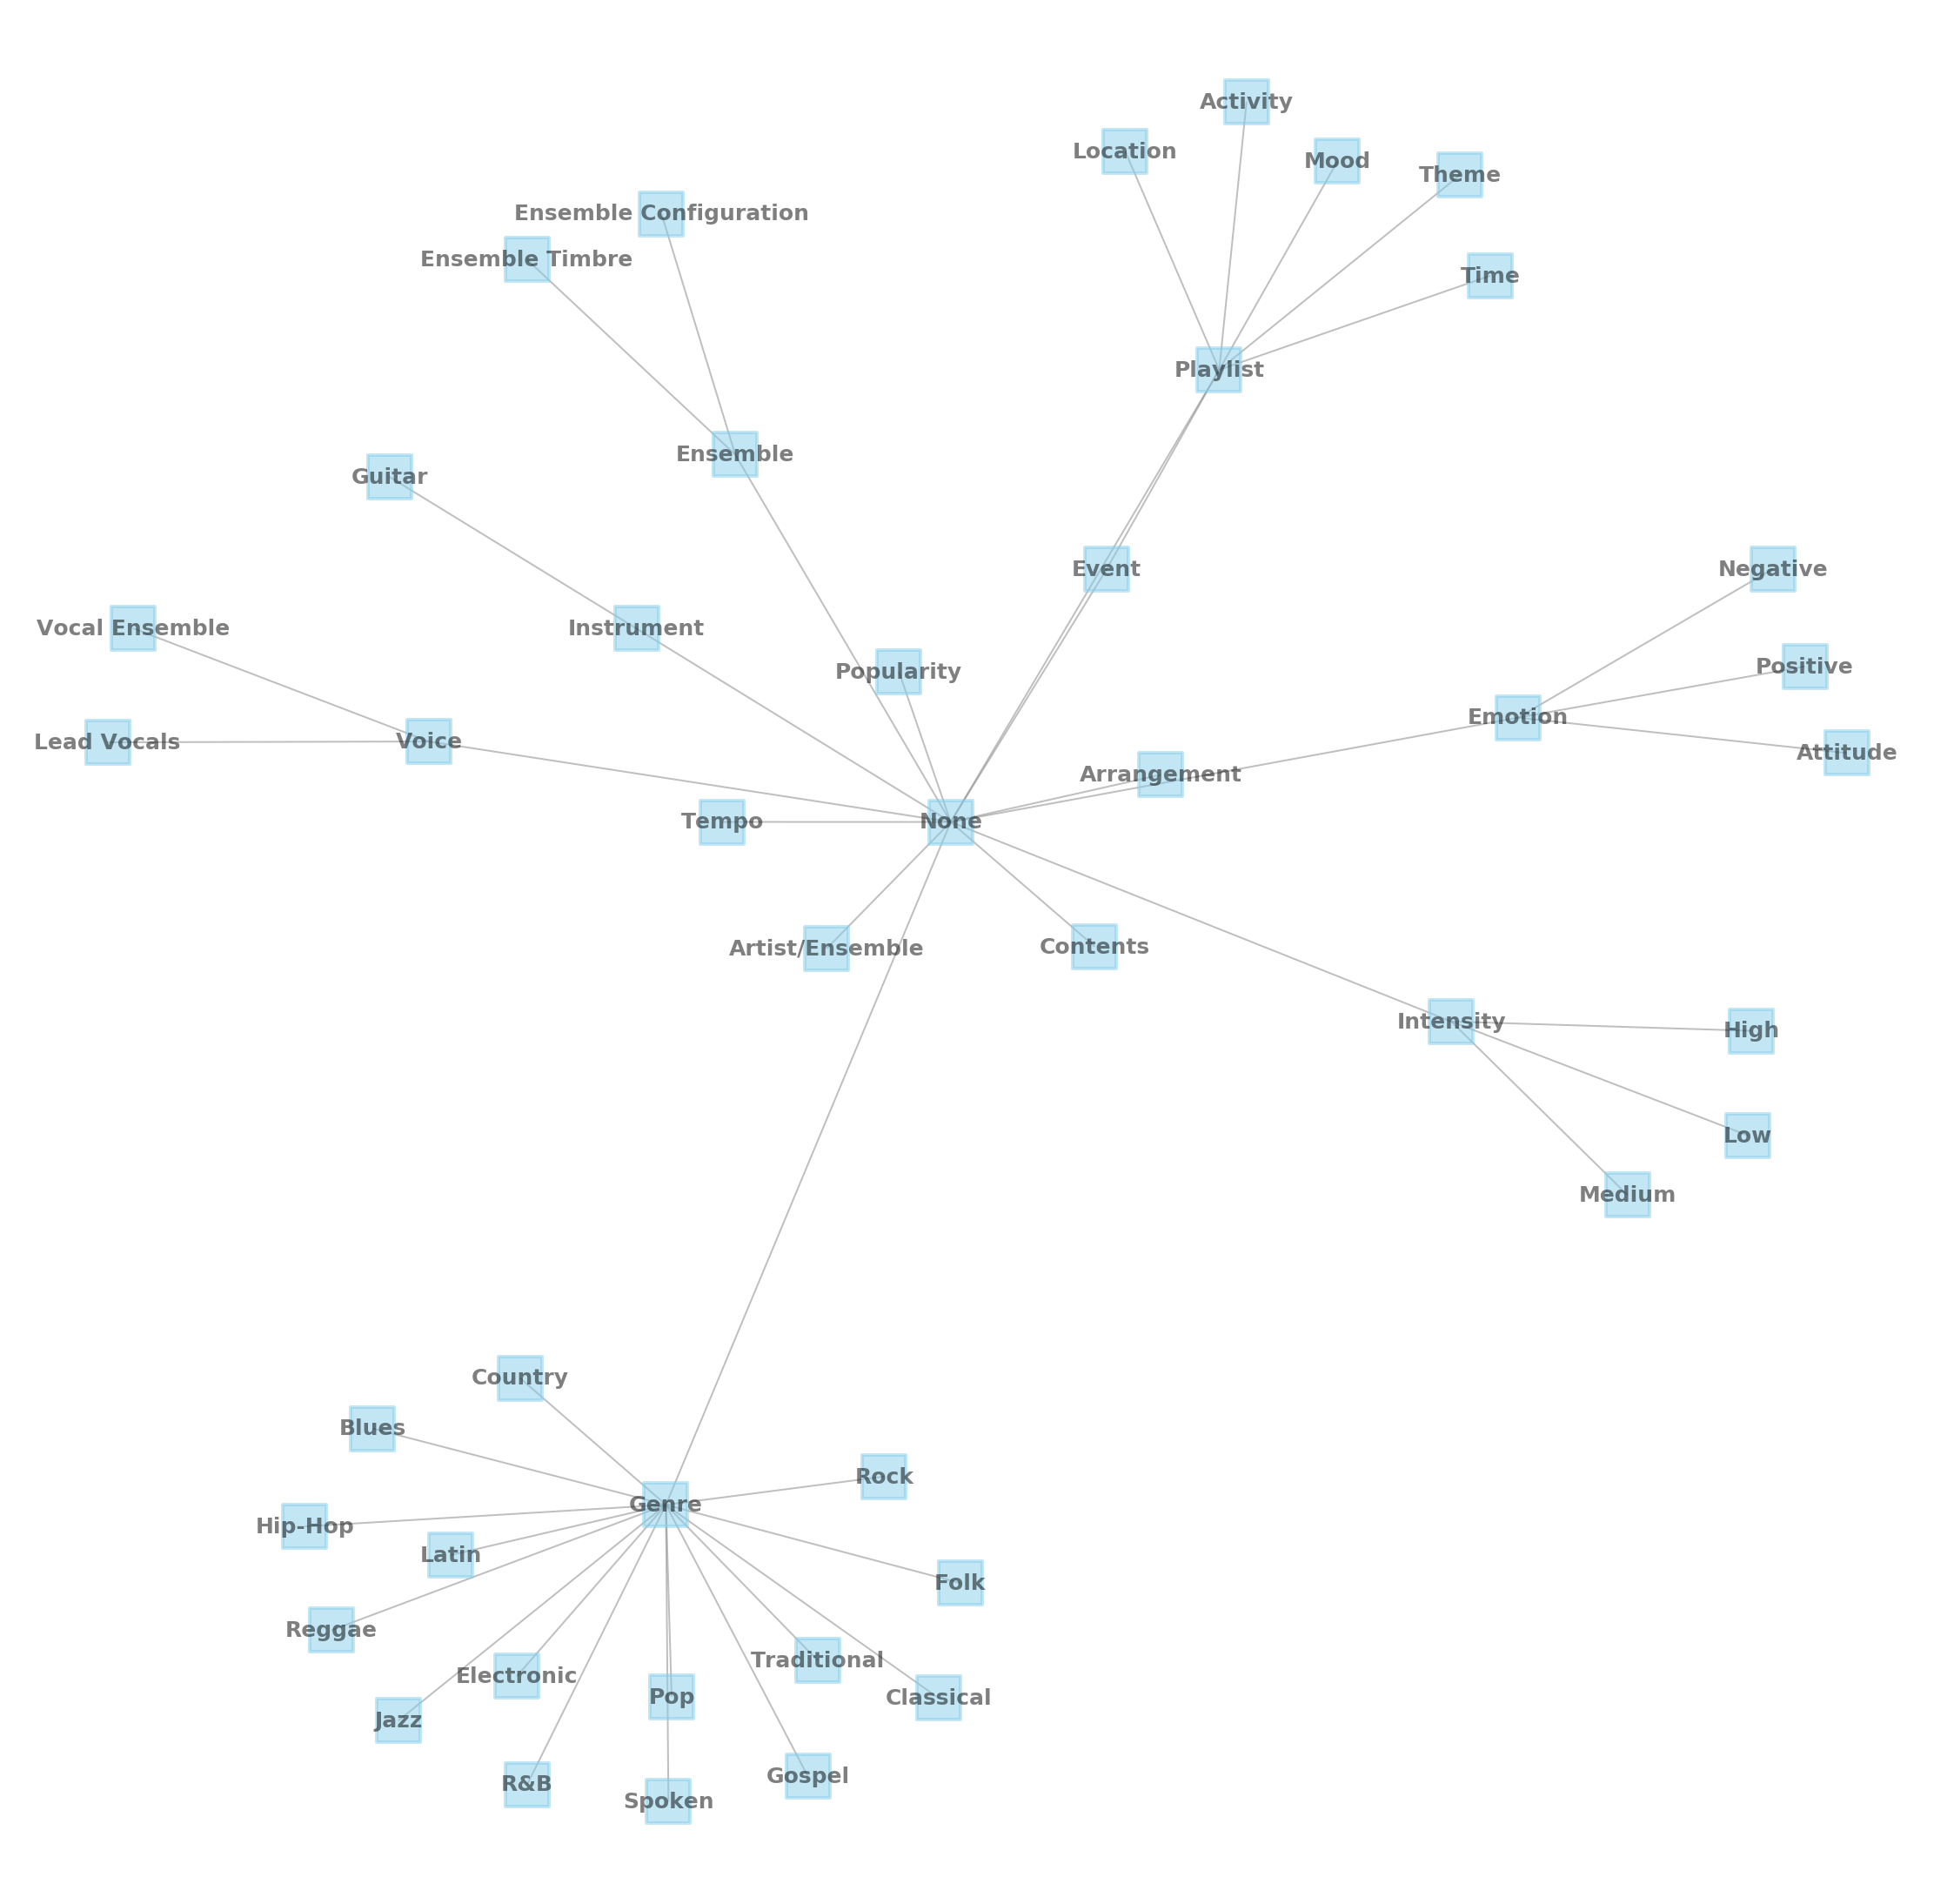

<Figure size 2880x2880 with 0 Axes>

In [48]:
# libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
 
# Build a dataframe with 4 connections
# df = pd.DataFrame({ 'from':['A', 'B', 'C','A'], 'to':['D', 'A', 'E','C']})
# df
 
# Build your graph
G=nx.from_pandas_edgelist(all_data_playlists, 'lvl_0', 'lvl_1')
 
# Plot it
fig, ax = plt.subplots(figsize=(40, 40))

ax = nx.draw(G, with_labels=True, node_size=2500, node_color="skyblue", node_shape="s", alpha=0.5, linewidths=4, 
             font_size=25, font_color="black", font_weight="bold", width=2, edge_color="grey")
plt.figure(figsize=(40,40))
plt.show()

In [25]:
# libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
 
# Build a dataframe with 4 connections
# df = pd.DataFrame({ 'from':['A', 'B', 'C','A'], 'to':['D', 'A', 'E','C']})
# df
 
# Build your graph
G=nx.from_pandas_edgelist(all_data_tracks, 'lvl_0', 'lvl_1')
 
# Plot it
fig, ax = plt.subplots(figsize=(40, 40))

ax = nx.draw(G, with_labels=True, node_size=2500, node_color="skyblue", node_shape="s", alpha=0.5, linewidths=4, 
             font_size=25, font_color="black", font_weight="bold", width=2, edge_color="grey")
plt.figure(figsize=(40,40))
plt.show()

NameError: name 'all_data_tracks' is not defined

In [191]:
all_data[(all_data.lvl_1=='Playlist')]

,lvl_0,lvl_1,lvl_2,lvl_3,lvl_4,description,name,taggable,taxonomynodeid,path
856,Application,Playlist,None,None,None,NaN,Activity,true,42f9d7e9-9133-4ddc-8a04-3c3b05a20ea8,Application/Playlist/Activity
857,Application,Playlist,Activity,None,None,NaN,Break-up,true,8c9aee2d-9c84-42e6-8f40-aaa1c6d3a3cf,Application/Playlist/Activity/Break-up
858,Application,Playlist,Activity,None,None,NaN,Celebration,true,b2f09caf-4629-4bda-9153-03a067006c3f,Application/Playlist/Activity/Celebration
859,Application,Playlist,Activity,None,None,NaN,Dancing,true,12870841-6d39-43cd-aa13-78c1b2545738,Application/Playlist/Activity/Dancing
860,Application,Playlist,Activity,None,None,NaN,Dating,true,ef0fce48-7185-4783-97ff-6bacc4ca5d51,Application/Playlist/Activity/Dating
861,Application,Playlist,Activity,None,None,NaN,Dinner,true,1df6d354-688f-45a6-b3be-2ccb62a76ce0,Application/Playlist/Activity/Dinner
862,Application,Playlist,Activity,None,None,NaN,Drinking,true,aa9bf721-64f1-47b2-87ff-e47f480d8889,Application/Playlist/Activity/Drinking
863,Application,Playlist,Activity,None,None,NaN,Driving,true,8fb8ad4e-f124-4ce7-9c28-1cfbf328d81b,Application/Playlist/Activity/Driving
864,Application,Playlist,Activity,None,None,NaN,Eating,true,57924078-3ef2-4611-abaf-9f9e9757f30b,Application/Playlist/Activity/Eating
865,Application,Playlist,Activity,None,None,NaN,Fighting,true,39d061b8-9e5c-45f8-8b0b-3cb440c1f81d,Application/Playlist/Activity/Fighting


In [77]:
all_data_playlists[(all_data_playlists.lvl_0=='Intensity')&(all_data_playlists.lvl_1.isnull()==True)].to_clipboard()

In [79]:
all_data_playlists[(all_data_playlists.lvl_0=='Emotion')&(all_data_playlists.lvl_1.isnull()==False)]

,lvl_0,lvl_1,lvl_2,description,name,taggable,taxonomynodeid,path
95,Emotion,Negative,None,"Strong, uncomfortable and hostile response to ...",Angry,true,3a305083-4df7-4780-a73f-6943ad894a08,Emotion/Negative/Angry
96,Emotion,Negative,None,"Tension, uneasiness and worry in reaction to t...",Anxious,true,85a4e4c5-879a-4f89-9b7f-7439b4d41932,Emotion/Negative/Anxious
97,Emotion,Negative,None,General emotional suffering.,Pained,true,4848d188-6ef4-4bb3-a385-74633ee6ae77,Emotion/Negative/Pained
98,Emotion,Negative,None,Distressing emotion aroused by the perception ...,Fearful,true,fba6c7c6-edfc-466f-86d2-1bdfbc401050,Emotion/Negative/Fearful
99,Emotion,Negative,None,Pensive sadness with no necessary or obvious c...,Melancholic,true,d0e0d85b-6f71-435b-ba9c-101b0f59339e,Emotion/Negative/Melancholic
100,Emotion,Negative,None,"Emotional pain associated with, or characteriz...",Sad,true,77822969-740e-4f56-9ea0-09de404dc071,Emotion/Negative/Sad
102,Emotion,Positive,None,"Enthusiastic, high-energy state.",Exciting,true,1e6e63c6-15dd-4767-9f0e-84d51a17091b,Emotion/Positive/Exciting
103,Emotion,Positive,None,"Light, pleasurable, and joyful.",Happy,true,89a8d7be-46bb-49e6-88e8-21c866598f05,Emotion/Positive/Happy
104,Emotion,Positive,None,Positive and cheerful.,Uplifting,true,9741eee3-4efe-4f60-b14e-2bc932c304a2,Emotion/Positive/Uplifting
105,Emotion,Positive,None,Fanciful and powerfully sentimental.,Romantic,true,5c55f7dd-506b-4310-9cfc-fd9242aa884e,Emotion/Positive/Romantic


In [192]:
all_data[all_data.lvl_1=='Playlist'].name.unique()

array(['Activity', 'Break-up', 'Celebration', 'Dancing', 'Dating',
       'Dinner', 'Drinking', 'Driving', 'Eating', 'Fighting',
       'Hanging Out', 'Karaoke/Sing-Along', 'Meditation', 'Party',
       'Wedding Reception', 'Relaxing', 'Road Trip', 'Running',
       'Sleeping', 'Study/Focus', 'Travel', 'Working', 'Working Out',
       'Yoga', 'Wedding', 'Victory', 'Defeat', 'Event', 'Armageddon',
       'Circus', 'Funeral', 'Graduation', 'Parade', 'War',
       'American Civil War', 'Crusades', 'Napoleonic Wars', 'Vietnam War',
       'World War I', 'World War II', 'Weather', 'Fog', 'Hurricane',
       'Lightning', 'Mist', 'Rain', 'Snow', 'Storm', 'Thunder', 'Tornado',
       'Wind', 'Location', 'Room', 'Home', 'Street', 'Neighborhood',
       'College/University', 'Village', 'Town', 'City', 'Country',
       'Continent', 'Africa', 'Asia', 'Australia', 'Europe',
       'Middle East', 'North America', 'Oceania', 'South America',
       'Ocean/Sea', 'Andaman Sea', 'Arctic Ocean', 'Atlant

In [190]:
all_data[all_data.lvl_1=='Playlist'].lvl_1.unique()

array(['Playlist'], dtype=object)